In [10]:
from neuralforecast import NeuralForecast as nf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from neuralforecast.models import NHITS, LSTM, NBEATSx
from neuralforecast.losses.pytorch import MQLoss

In [11]:
# import from one folder back src.utils fix_index_to_1h
import sys
sys.path.append("..")
from WewerForecast.utils import fix_index_to_1h



In [12]:
# load data
# load excel files from ../data/raw/WDSA into a pandas dataframe, col 0 Date-time CET-CEST (DD/MM/YYYY HH:mm)
df_inflow = pd.read_excel(r'../data/raw/WDSA/InflowData_1.xlsx', index_col=0, parse_dates=True, date_format='%d/%m/%Y %H:%M')
df_weather = pd.read_excel(r'../data/raw/WDSA/WeatherData_1.xlsx', index_col=0, parse_dates=True, date_format='%d/%m/%Y %H:%M')

# get latest start date of both datasets
start_date = max(df_inflow.dropna().index.min(), df_weather.dropna().index.min())

# get earliest end date of both datasets
end_date = min(df_inflow.dropna().index.max(), df_weather.dropna().index.max())

# get the intersection of both datasets
df_inflow = df_inflow.loc[start_date:end_date]
df_weather = df_weather.loc[start_date:end_date]

df_inflow = fix_index_to_1h(df_inflow)
df_weather = fix_index_to_1h(df_weather)

# add binary column to df_weather that indicates if it is weekend or midweek, make sure it is an integer
df_weather['IsWeekend'] = (df_weather.index.dayofweek > 4).astype(float)

# add hour of the day as a column to both dataframes
df_weather['Hour'] = df_weather.index.hour.astype(float)


# merge datasets
df = pd.merge(df_inflow, df_weather, left_index=True, right_index=True)
df = df.interpolate(method='linear')

# ['ds', 'unique_id', 'y']
df['unique_id'] = '1'
df['ds'] = df.index

# rename DMA A (L/s) to y
df.rename(columns={'DMA A (L/s)': 'y'}, inplace=True)

df.reset_index(drop=True, inplace=True)

In [13]:
df

,y,DMA B (L/s),DMA C (L/s),DMA D (L/s),DMA E (L/s),DMA F (L/s),DMA G (L/s),DMA H (L/s),DMA I (L/s),DMA J (L/s),Rainfall depth (mm),Air temperature (°C),Air humidity (%),Windspeed (km/h),IsWeekend,Hour,unique_id,ds
0,7.7800,9.9550,5.3500,40.6325,93.3300,9.3350,26.35250,22.6350,18.9875,25.3200,0.0,4.7,34.0,13.0,1.0,20.0,1,2021-02-14 20:00:00
1,7.1800,9.2800,4.8775,34.8850,83.8825,7.0250,21.78750,19.4700,18.9200,23.6500,0.0,4.0,42.0,19.0,1.0,21.0,1,2021-02-14 21:00:00
2,6.0825,9.0275,4.3500,30.2525,76.7000,7.6550,19.36000,16.9900,18.4250,22.8900,0.0,3.7,41.0,27.0,1.0,22.0,1,2021-02-14 22:00:00
3,5.2475,8.4900,3.9825,27.4275,72.4500,7.4750,17.47000,15.6350,18.1825,21.1750,0.0,3.4,39.0,34.0,1.0,23.0,1,2021-02-14 23:00:00
4,5.0425,7.9250,3.5750,22.8050,64.4450,7.8750,15.06750,13.5725,18.9850,21.8475,0.0,2.7,37.0,30.0,0.0,0.0,1,2021-02-15 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12602,12.9175,17.7050,10.0100,38.7900,93.9925,8.3325,35.45000,21.7350,19.5050,28.4350,0.0,29.8,70.0,4.0,1.0,19.0,1,2022-07-24 19:00:00
12603,12.8400,17.3500,10.0550,41.6675,93.1325,10.1300,37.97750,19.9700,19.7125,30.0125,0.0,29.3,66.0,2.0,1.0,20.0,1,2022-07-24 20:00:00
12604,11.5575,14.8400,8.0775,42.8400,90.6625,8.1550,34.32875,21.1200,18.7925,26.8800,0.0,29.5,60.0,2.0,1.0,21.0,1,2022-07-24 21:00:00
12605,10.4175,12.6925,6.1875,32.8325,83.1500,9.4225,30.68000,19.8600,18.7275,25.5650,0.0,28.6,67.0,3.0,1.0,22.0,1,2022-07-24 22:00:00


In [14]:
# turn df into df_train and df_test at 75% split
df_train = df.iloc[:int(len(df)*0.75)]
df_test = df.iloc[int(len(df)*0.75):]

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]

In [21]:
h = 24*7
input_size = 24*7
quantiles = [i*0.1 for i in range(1,10)]
model_nhits = NHITS(h=h,
              input_size=input_size,
              loss=MQLoss(quantiles=[i*0.1 for i in range(1,10)]),
              hist_exog_list=['Air temperature (°C)', 'Air humidity (%)', 'Windspeed (km/h)', 'IsWeekend', 'Hour'],
              futr_exog_list=['Air temperature (°C)', 'Air humidity (%)', 'Windspeed (km/h)', 'IsWeekend', 'Hour'],
              scaler_type='standard',
              max_steps=500,
              batch_size=32,
              val_check_steps=10,
              learning_rate=1e-3,
              )

# model_lstm = LSTM(h=24*7,
#                 input_size=24*7,
#                 loss=MQLoss(quantiles=[0.1, 0.5, 0.9]),
#                 hist_exog_list=['Air temperature (°C)', 'Air humidity (%)', 'Windspeed (km/h)', 'IsWeekend', 'Hour'],
#                 futr_exog_list=['Air temperature (°C)', 'Air humidity (%)', 'Windspeed (km/h)', 'IsWeekend', 'Hour'],
#                 scaler_type='standard',
#                 max_steps=100,
#                 batch_size=32,
#                 val_check_steps=10,
#                 learning_rate=1e-3,
#                 )

# model_nbeatsx = NBEATSx(h=24*7,
#                         input_size=24*7,
#                 loss=MQLoss(quantiles=[0.1, 0.5, 0.9]),
#                 hist_exog_list=['Air temperature (°C)', 'Air humidity (%)', 'Windspeed (km/h)', 'IsWeekend', 'Hour'],
#                 futr_exog_list=['Air temperature (°C)', 'Air humidity (%)', 'Windspeed (km/h)', 'IsWeekend', 'Hour'],
#                 scaler_type='standard',
#                 max_steps=100,
#                 batch_size=32,
#                 val_check_steps=10,
#                 learning_rate=1e-3,
#                 )
fcst = nf(models=[model_nhits], freq='h')
fcst.fit(df=df_train, val_size=2*24*7)




Seed set to 1


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s, v_num=18, train_loss_step=0.108, train_loss_epoch=0.108, valid_loss=0.486]


In [40]:

forecasts = fcst.predict(futr_df=df_test[:168])
df_out = df_test[['y', 'ds']]
# merge df_out on the forecasts df on the 'ds' column
df_out = pd.merge(df_out, forecasts, on='ds')
df_out.drop(columns=['ds'], inplace=True)



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.85it/s]


In [ ]:
MQLos

IndexError: list index out of range

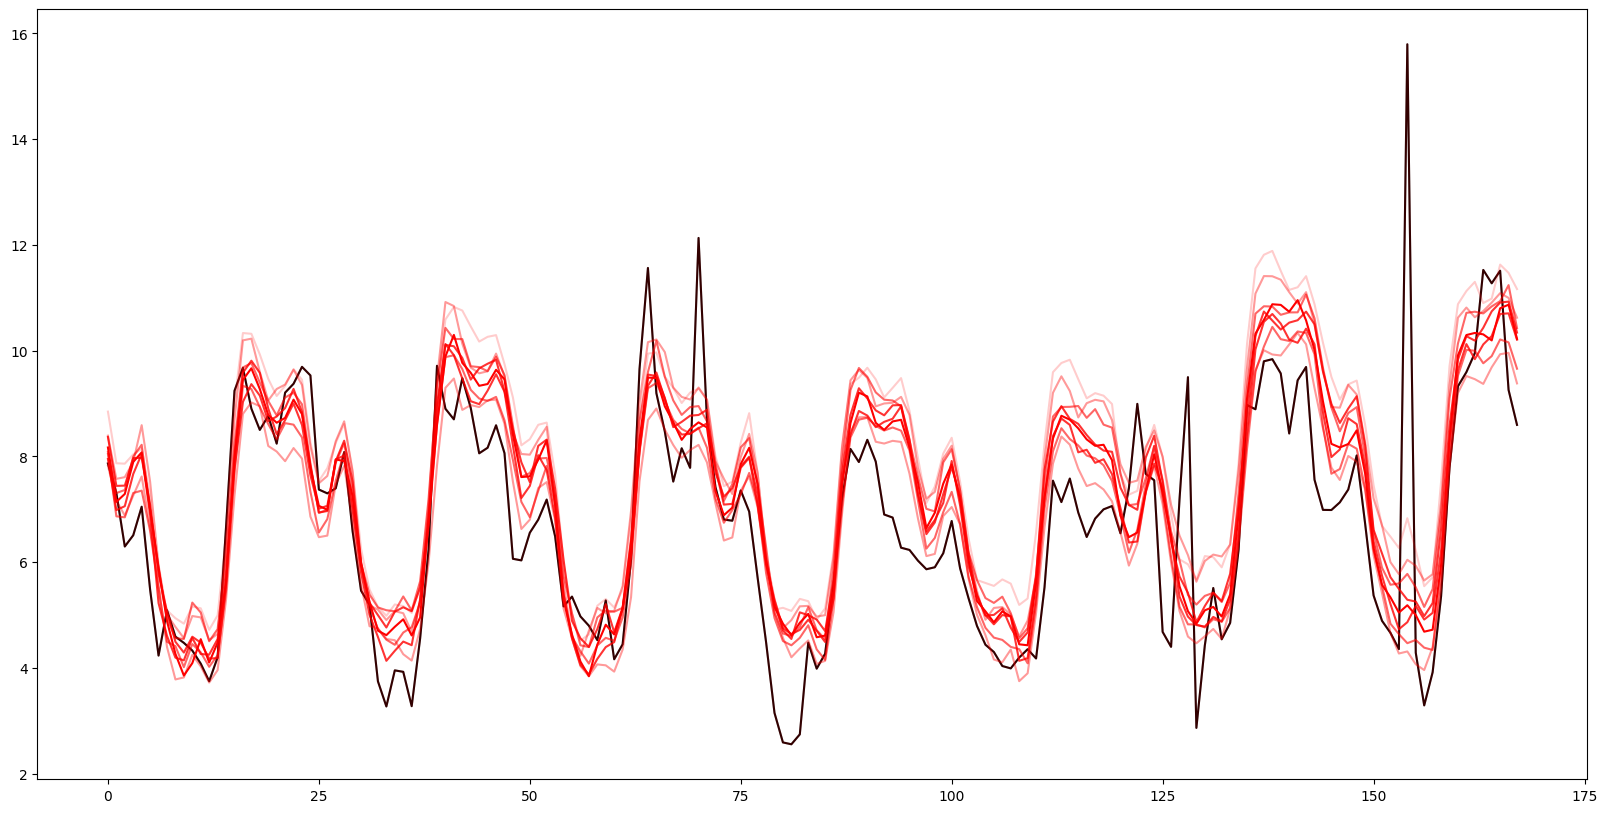

In [41]:
# y	ds	NHITS-lo-80.0	NHITS-lo-60.0	NHITS-lo-40.0	NHITS-lo-20.0	NHITS-median	NHITS-hi-20.0	NHITS-hi-40.0	NHITS-hi-60.0	NHITS-hi-80.0
# remove y, ds from df_out
# plot df out, plot NHITS-median in black, the quantiles in red
# have alpha value for quantiles, adjusted with quantile. lower quantile is lower alpha
alpha = [0.2, 0.4, 0.6, 0.8, 1, 0.8, 0.6, 0.4, 0.2]

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_out['y'], label='y', color='black')
for i, col in enumerate(df_out[1:]):
    ax.plot(df_out[col], label=col, alpha=alpha[i], color='red')

    


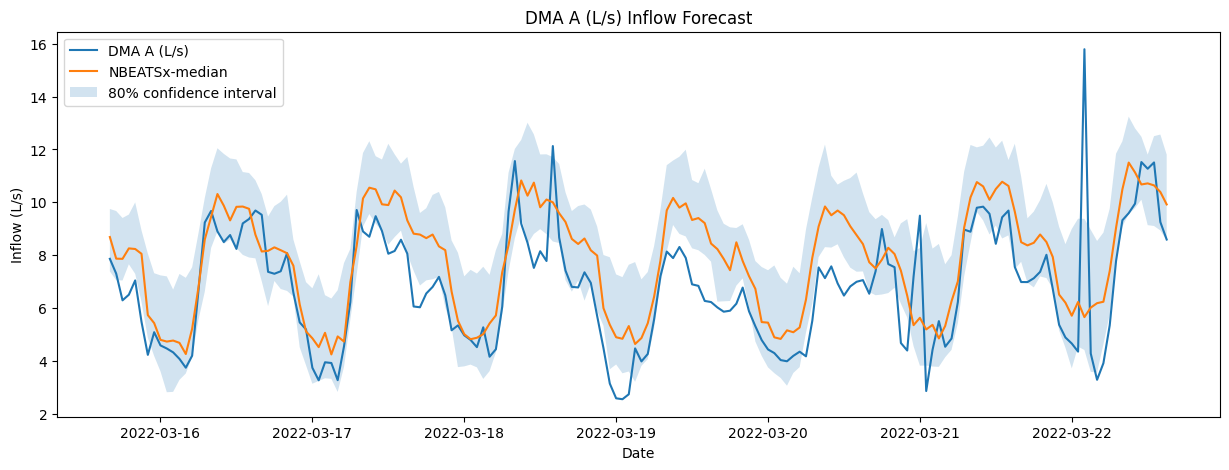

In [73]:
# y	ds	NHITS-lo-80.0	NHITS-median	NHITS-hi-80.0
# fig, ax = plt.subplots(figsize=(15, 5))
# ax.plot(df_out['ds'], df_out['y'], label='DMA A (L/s)')
# ax.plot(df_out['ds'], df_out['NBEATSx-median'], label='NBEATSx-median')
# ax.fill_between(df_out['ds'], df_out['NBEATSx-lo-80.0'], df_out['NBEATSx-hi-80.0'], alpha=0.2, label='80% confidence interval')
# ax.set_xlabel('Date')
# ax.set_ylabel('Inflow (L/s)')
# ax.set_title('DMA A (L/s) Inflow Forecast')
# ax.legend()
# plt.show()


